# 01 Image Classification

In this notebook we will try and perform image classification on the [ImageWoof](https://github.com/fastai/imagenette) dataset. This dataset is a subset of ImageNet composing of 10 different dog breeds. 

## Roadmap:

* Installing and importing the library
* Applying the `DataBlock`
* Get a baseline Resnet34 model
* Introduce techniques such as MixUp and Test-Time-Augmentation

## Installing and importing the library

As a recent update to `torchvision` and `torch` were released, installing the proper versions for our `CUDA` environment isn't as simple as `pip install torch`. That being said there is a package called `light-the-torch` to make this easier. Let's install `torch` along with the `fastai` libraries:

> Note: the below code may take a minute or two to run

In [ ]:
!pip install light-the-torch >> /.tmp
!ltt install torch torchvision >> /.tmp
!pip install fastai nbdev --upgrade >> /.tmp

Next we will import the library. At this current time `fastai` has four submodules:
  * `vision`
  * `text`
  * `tabular`
  * `collab`

We'll be using the `vision` library in this example and `tabular` for the next. 

`fastai` leverages on a `.all` import system, allowing for helpful functions to be available in the current namespace:

In [ ]:
from fastai.vision.all import *

## Applying the `DataBlock`

Next we'll need to build our `DataBlock` to make our `DataLoaders`. First let's download the data through the `untar_data` command:

In [ ]:
path = untar_data(URLs.IMAGEWOOF)

Let's look at how the data is stored:

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/imagewoof2/val'),Path('/root/.fastai/data/imagewoof2/train')]

So we can see that our data is split between `train` and `val` folders. How are the labels stored?

In [ ]:
(path/'train').ls()[:2]

(#2) [Path('/root/.fastai/data/imagewoof2/train/n02096294'),Path('/root/.fastai/data/imagewoof2/train/n02089973')]

So the folder names are their labels.

How does this align to what we need for that `DataBlock` outline?

In [ ]:
blocks = (ImageBlock, CategoryBlock)
get_items = get_image_files
splitter = GrandparentSplitter(train_name='train', valid_name='val')
get_y = parent_label

Next we'll define some basic augmentation for our dataset:

In [ ]:
item_tfms = [Resize(448)]
batch_tfms = [FlipItem(), RandomResizedCrop(128, min_scale=0.35), 
              Normalize.from_stats(*imagenet_stats)]

What else can we do? 

`fastai` operates on a `Transform` pipeline. What that means is `tfms` no longer are just limited to data augmentation. Let's write a `Transform` that can covert the strange folder name into something readable:

In [ ]:
lbl_dict = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

Let's see an example:

In [ ]:
item = (path/'train').ls()[0]
print(item.name)

n02096294


In [ ]:
lbl_dict[item.name]

'Border terrier'

Now how do we add this to our `DataBlock`?

We would put this on our `get_y`, when we get our labels

In [ ]:
get_y = Pipeline([parent_label, lbl_dict.__getitem__])

Finally, let's put it all together in the `DataBlock` API:

In [ ]:
block = DataBlock(blocks=blocks,
                  get_items=get_items,
                  get_y=get_y,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms)

The `DataBlock` is simply a blueprint of our data pipeline. To build our dataloaders we need to pass in some items to use as well as a batch size. In this case it's the path to our data:

In [ ]:
dls = block.dataloaders(path, bs=64)

And we can look at some of our data by calling `show_batch`:

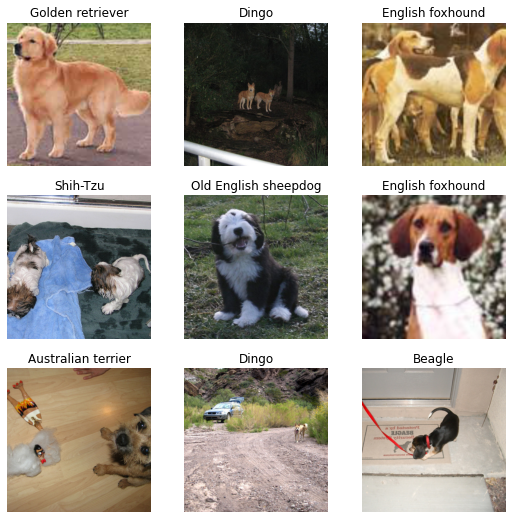

In [ ]:
dls.show_batch()

## Getting a baseline with Resnet34

Next we'll apply some Transfer Learning to our dataset to help speed up training and potentially improve accuracy.

`fastai`'s training pipeline is facilitated through a `Learner` object. There are a series of `_learner` functions to help make buiding a `Learner` for your task easier. 

Since we are using images our function is `cnn_learner` (Convolutional Neural Network). Let's look at its documentation:

In [ ]:
doc(cnn_learner)

So as we can see `fastai` will want us to pass in some `DataLoaders`, a *callable* `arch`, and that is the bare minimum of what we need. We'll also pass in a metric to use that will help us make sense of the results as we train:

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy])

It will then go and download the weights for a resnet34 architecture and apply fastai's own custom head on top

Finally, we can train using the `fine_tune` method and passing in the number of epochs to train for

> Note: it will train for `n`+1 epochs as by default `fine_tune` will train your model frozen for one epoch

In [ ]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.465481,0.198776,0.937066,02:04


epoch,train_loss,valid_loss,accuracy,time
0,0.270244,0.183124,0.946332,02:08


94% accuracy is not bad at all after 2 epochs! Let's see an inference example live:

In [ ]:
item = get_image_files(path)[0]

In [ ]:
learn.predict(item)

('Border terrier',
 tensor(2),
 tensor([2.3234e-03, 2.9749e-08, 9.9768e-01, 2.9320e-09, 1.1825e-07, 1.5182e-07,
         2.2003e-07, 5.0878e-08, 7.2349e-08, 7.0727e-08]))

We can see the class name, the class index, and the probabilities

## Introduce techniques such as MixUp and Test-Time-Augmentation

Let's see how easy it is to perform these two techniques in the `fastai` library. First let's look at `Test-Time-Augmentation`

In fastai it's shortcut is `learn.tta()` which will return raw softmax'd probabilites, as we saw earlier:

In [ ]:
tta_preds = learn.tta(ds_idx=1)

Let's also compare it with our regular predictions:

In [ ]:
preds = learn.get_preds(ds_idx=1)

In [ ]:
accuracy(*preds)

TensorCategory(0.9463)

In [ ]:
accuracy(*tta_preds)

TensorCategory(0.9506)

We improved our accuracy by 1/2 a percent!

To use MixUp during training we would modify our fit function like so:

In [ ]:
learn.fine_tune(1, cbs=[MixUp()])